In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch

In [86]:
seed = 42

torch.random.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)

batch_size = 128
lr = 2e-3
epochs = 30

device = "cuda" if torch.cuda.is_available() else "cpu"

root_path = "E:\\IOAI\\kits\\onia-2025"

# Data preparation

In [87]:
class BabilonianTrainDataset(Dataset):
    def __init__(self):
        self.df = pd.read_csv("train_data.csv")
        
        self.label2idx = {label: idx for idx, label in enumerate(self.df["Effect"].unique())}
        self.idx2label = {self.label2idx[label]: label for label in self.label2idx.keys()}

        self.transforms = transforms.Compose([
            transforms.Resize((48, 48)),

            transforms.RandomRotation(10),
            transforms.RandomResizedCrop(48, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),

            transforms.ToTensor(),
        ])

    def get_labels(self, indices):
        labels = []
        for index in indices:
            labels.append(self.idx2label[index])
        return labels

    def __getitem__(self, idx):
        img_row = self.df.iloc[idx]

        img_path = f"{root_path}/{img_row['Path']}"
        img = Image.open(img_path).convert("L")
        img = self.transforms(img)

        label = self.label2idx[img_row["Effect"]]

        img, label = img.to(device), torch.tensor(label, dtype=torch.uint8, device=device)
        return img, label

    def __len__(self):
        return len(self.df)

In [88]:
train_dataset = BabilonianTrainDataset()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

torch.Size([128, 1, 48, 48])
5


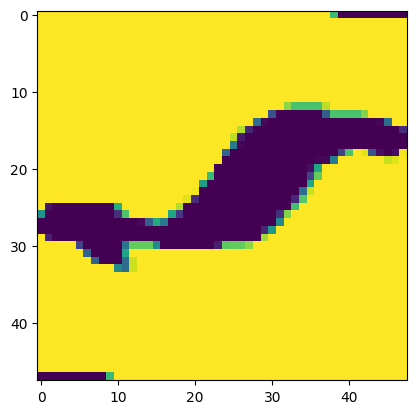

In [89]:
# sanity check
img_batch, label_batch = next(iter(train_loader))
print(img_batch.shape)
img, label = img_batch[0].cpu(), label_batch[0]

print(label.item())
plt.imshow(img.permute(1, 2, 0))

# Model selection

In [90]:
class BabilonianCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(BabilonianCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(64 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        
        return self.fc2(x)

In [91]:
model = BabilonianCNN().to(device)

criterion = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters(), lr=lr)

In [92]:
# sanity check
model(next(iter(train_loader))[0]).shape

torch.Size([128, 8])

In [93]:
losses = []

for epoch in range(epochs+1):
    model.train()
    running_loss = 0

    for img, label in train_loader:
        # forward pass
        pred = model(img)
        loss = criterion(pred, label)

        # backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()

        # stats for nerds
        running_loss += loss.item()
    losses.append(running_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {running_loss:.4f}")

Epoch 0/30, Loss: 14.5904
Epoch 5/30, Loss: 1.9013
Epoch 10/30, Loss: 0.8857
Epoch 15/30, Loss: 0.5018
Epoch 20/30, Loss: 0.4323
Epoch 25/30, Loss: 0.2672
Epoch 30/30, Loss: 0.1876


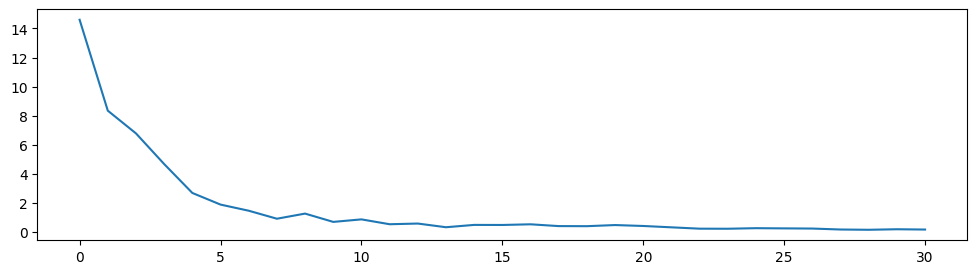

In [94]:
plt.figure(figsize=(12, 3))
plt.plot(range(epochs+1), losses)

# Evaluation data preparation

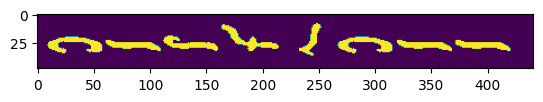

In [95]:
# first of all, test the operations we will later use to select the paches
df_test = pd.read_csv("test_data.csv")

# read a grayscale (for debug) image, binarize it
path = f"{root_path}/{df_test.iloc[120]['datapointID']}"
img = cv.imread(path, cv.IMREAD_GRAYSCALE)
_, img = cv.threshold(img, 160, 255, cv.THRESH_BINARY)

# remove the background
blur = cv.GaussianBlur(img, (3, 3), cv.BORDER_DEFAULT)
thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 15, 10)
inverted = cv.bitwise_not(thresh)  # or just ~thresh

plt.imshow(inverted)

found 8 things


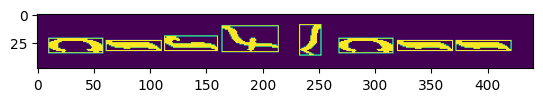

In [96]:
# find the contours of the babilonian things
thresh = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 15, 10)
contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

print(f"found {len(contours)} things")
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    cv.rectangle(thresh, (x, y), (x + w, y + h), 255, 1)
plt.imshow(thresh)

In [97]:
# just put togheter the stuff from above
def remove_background(img, min_area=30):
    _, img = cv.threshold(img, 160, 255, cv.THRESH_BINARY)

    blur = cv.GaussianBlur(img, (3, 3), cv.BORDER_DEFAULT)
    thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 15, 10)

    return thresh


def extract_patches(img, min_area=30, pad=2):
    img = remove_background(img)
    thresh = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 15, 10)
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    patches = []
    for cnt in contours:
        x, y, w, h = cv.boundingRect(cnt)
        if w * h < min_area:
            continue

        x_start = max(x - pad, 0)
        y_start = max(y - pad, 0)
        x_end = min(x + w + pad, img.shape[1])
        y_end = min(y + h + pad, img.shape[0])
        patch = img[y_start:y_end, x_start:x_end]
        
        patches.append((x_start, patch))
    
    # we want the patches to be in the order they appear in the original images
    patches = [patch for _, patch in sorted(patches, key=lambda p: p[0])]
    return patches

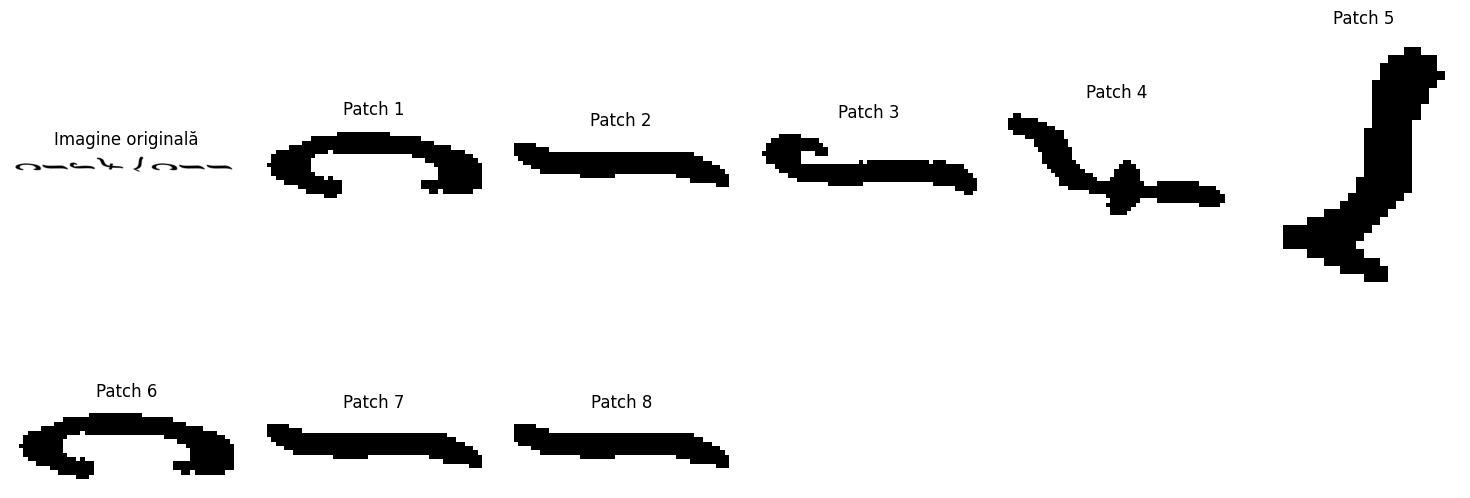

In [98]:
path = f"{root_path}/{df_test.iloc[120]['datapointID']}"
img = cv.imread(path, cv.IMREAD_GRAYSCALE)
patches = extract_patches(img)

cols = 6
rows = int(np.ceil((len(patches) + 1) / cols))
plt.figure(figsize=(15, 3 * rows))
plt.subplot(rows, cols, 1)
plt.title('Imagine originală')
plt.axis('off')
plt.imshow(img, cmap='gray')

for i, patch in enumerate(patches):
    plt.subplot(rows, cols, i + 2)
    plt.title(f'Patch {i + 1}')
    plt.axis('off')
    plt.imshow(patch, cmap='gray')
plt.tight_layout()
plt.show()

In [99]:
class BabilonianTestDataset(Dataset):
    def __init__(self):
        self.df = pd.read_csv("test_data.csv")

        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((48, 48)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __getitem__(self, idx):
        path = f"{root_path}/{df_test.iloc[idx]['datapointID']}"
        img = cv.imread(path, cv.IMREAD_GRAYSCALE)

        raw_patches = extract_patches(img)

        patches = []
        for patch in raw_patches:
            patches.append(self.transforms(patch).unsqueeze(0))
        patches = torch.vstack(patches)

        return patches.squeeze(0), df_test.iloc[idx]["datapointID"]

    def __len__(self):
        return len(self.df)

In [100]:
test_dataset = BabilonianTestDataset()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [101]:
batch, did = next(iter(test_loader))
batch[0].shape, did[0]

(torch.Size([11, 1, 48, 48]), 'eval_img/1085.png')

# Submission

In [102]:
def encode_prediction(predictions):
    result = []
    for pred in predictions:
        if len(result) == 0 and (pred == 'A' or pred == 'B'):
            result.append(0)
        elif len(result) == 0:
            result.append(int(pred))
        elif pred == 'A' or pred == 'B':
            result.append(result[-1])
        else:
            result.append(result[-1] + int(pred))
    final_result = str(result[0])
    for item in result[1:]:
        final_result += "|" + str(item)
    return final_result

In [103]:
submission = {"subtaskID": [], "datapointID": [], "answer": []}

model.eval()
for patches, datapoint_id in test_loader:
    patches = patches[0].to(device)

    if len(patches.shape) == 3:
        patches = patches.unsqueeze(0)
    pred = model(patches)
    y_pred = pred.argmax(dim=1).cpu().numpy()

    labels = train_dataset.get_labels(y_pred)
    pred = encode_prediction(labels)

    submission["subtaskID"].append(1)
    submission["datapointID"].append(datapoint_id[0])
    submission["answer"].append(pred)

In [104]:
submission = pd.DataFrame(submission)
submission.head()

,subtaskID,datapointID,answer
0,1,eval_img/2033.png,4|4|2|6|6|10|6|6|6|2
1,1,eval_img/s6r.png,-4|-8|-12|-16|-20|-24
2,1,eval_img/3015.png,-1|3|-1|-5|-5|-9|-9|-13|-12|-16|-18|-22
3,1,eval_img/3021.png,-4|-5|-9|-8|-12|-16|-16|-20|-16|-17|-17|-17|-1...
4,1,eval_img/71.png,0|0|0|0|0


In [105]:
submission.to_csv("submission.csv", index=False)